# Time Series Analysis for Netflix

### By Nicole Haberer
### March 14, 2019

### Summary:
The goal of this analysis is to understand the driving factors behind Google search interest for Netflix. Our main area of analysis will be advertising expenditure by outlet and type. 

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as pyplot
import pandas as pd
import numpy as np
from statsmodels.tsa import seasonal
from fbprophet import Prophet
import holidays
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from statistics import mode
from statsmodels.tsa import stattools
import seaborn as sns

We obtained GoogleTrends data for 2014 to 2018 from the GoogleTrends API. We start by identifying each column as a day and then taking a look at the initial raw data.

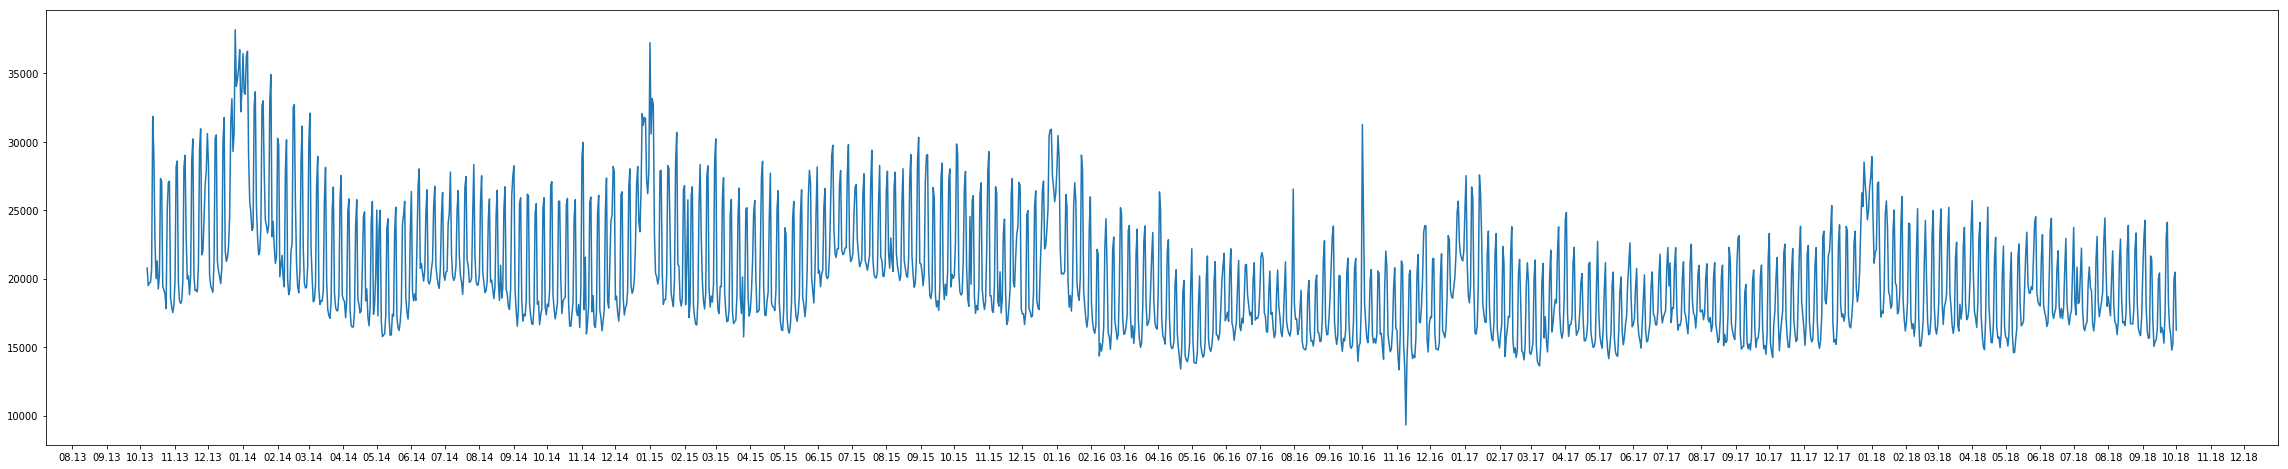

In [2]:
netflix = pd.read_csv("netflix.googletrends.csv", parse_dates=['period']) 
netflix['period'] = netflix['period'].dt.date
netflix.set_index('period', inplace=True)

dimensions = (40,8)
fig, ax = pyplot.subplots(figsize=dimensions)
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearmonth = mdates.DateFormatter('%m.%y')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)
ax.plot(netflix.index, netflix['value'])

An initial survey of this data shows us a slight downward trend and an annual spike trend. Let's dive deeper using different forms of analysis to see if we can get more details about what's going on here.

We will start by minimizing residuals and picking a seasonal pattern based on year.

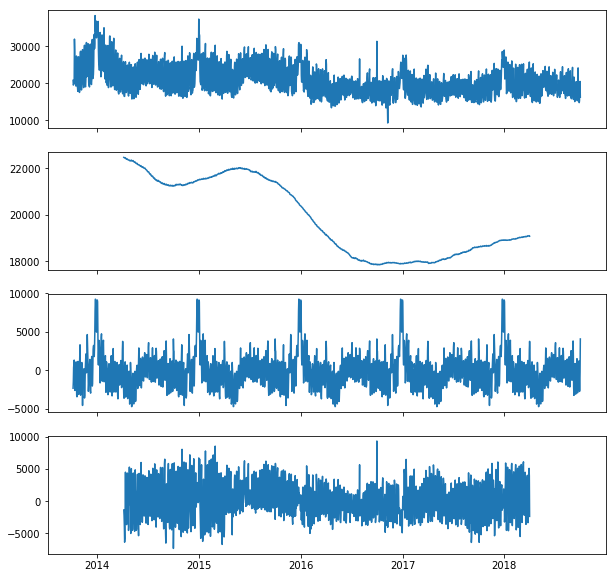

In [3]:
decompose_model = seasonal.seasonal_decompose(netflix['value'].tolist(), freq=365, model='additive')
dir(decompose_model)

dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex ='all')

ax1.plot(netflix.index, netflix['value'])
ax2.plot(netflix.index, decompose_model.trend)
ax3.plot(netflix.index, decompose_model.seasonal)
ax4.plot(netflix.index, decompose_model.resid)

Splitting our information into 4 different charts is certainly more informative. 

The first chart is identical to our original model and shows our values over time.

The second chart confirms our concern that we are seeing an overall downward trend beginning mid-year in 2015. A drop from 22,000 in 2015 to 18,000 in 2016 is around a 20% decrease in volume of overall searches. This is a significant loss of volume and we will need to dive in deeper to see if we can attribute this decline to a specific set of factors.

The third chart confirms our theory that there is a strong year over year seasonal trend with most searches occurring in the holiday season between Thanksgiving and New Year's. This is a clear indication of a consumer driven trend as people are more likely to search for and watch movies during holidays and free time.  

The final chart shows our model's residuals, indicating there are moments of greater and less accuracy depending on year and season.

Next: Let's add a seasonal column to our dataset and see what happens when we compare our predicted seasonal pattern with what actually happened.

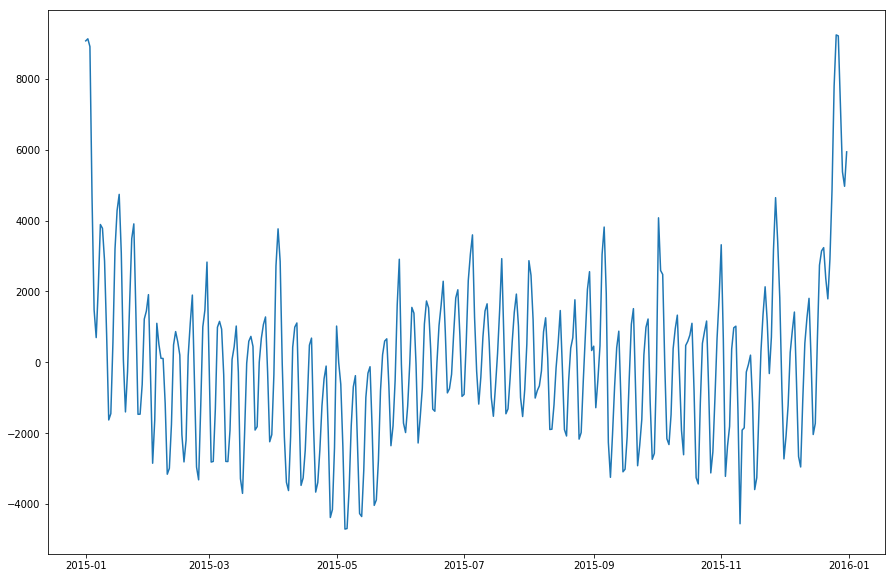

In [4]:
netflix['seasonal'] = decompose_model.seasonal
startdate = pd.to_datetime("2015-01-01").date()
enddate = pd.to_datetime("2015-12-31").date()
oneyear = netflix.loc[startdate:enddate]

dimensions = (15,10)
fig, ax1 = pyplot.subplots(figsize=dimensions)
pyplot.plot(oneyear.index, oneyear.seasonal)

When using a test year of 2015 we can see how well our model's predictions are doing compared to what really happened.

It is obvious there is a lot of room for improvement in our model so let's try Facebook Prophet to see if that can get our predictions closer to actual values.

In [5]:
netflix2 = pd.read_csv('netflix.googletrends.csv', parse_dates=['period'])

prophetdataframe = pd.DataFrame()
prophetdataframe['ds'] = netflix2['period']
prophetdataframe['y'] = netflix2['value']
m = Prophet()
m.fit(prophetdataframe)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Let's start by using Prophet to predict out the next 365 days.

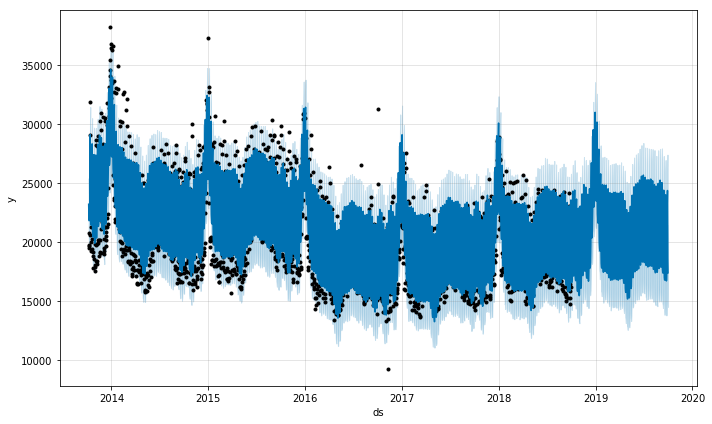

In [6]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

So, what's going on in this graph?

The black dots are observed values.

The darkest shade of blue is the error in the observation for each day so the wider the bar, the more error we are seeing in our model.

The light blue shade is the confidence interval at the 95th percentile.

The better our model, the more we will see our actual values fall within the light blue range.

This graph is pretty informative, but Prophet will actualyl let us dive deeper to see more of this seasonality.

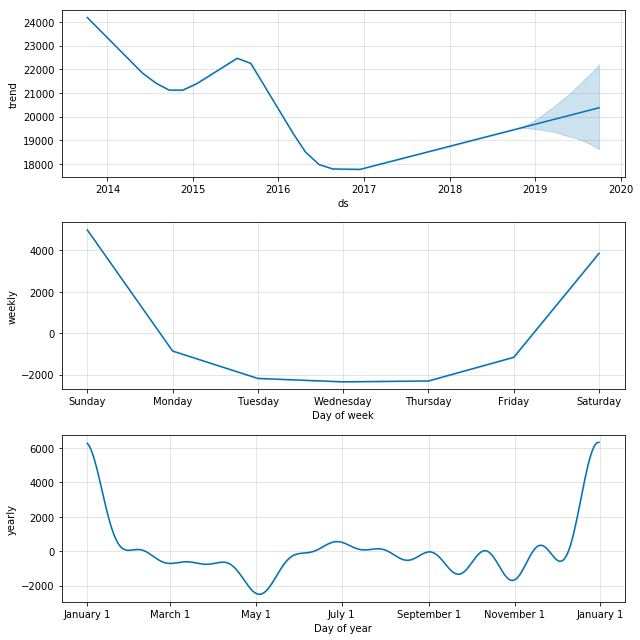

In [7]:
fig2 = m.plot_components(forecast)

First, we see yearly trend. The model is trying to calculate moving trend on an annual basis. We can see there is a wide area of prediction for the next year as Prophet tries to decide if we will continue to recover from our 2016 slump or if our search volum will once again start to decay.

Second, we see the weekly treand where the greatest search volume is clearly concentrated on the weekends with the least activity occurring on Wednesdays.

Third, we see monthly seasonality where most of the year is relatively constant, but there are huge spikes around the holiday break season. Low peak season is in May when people are excited to finally enjoy the nice weather, but in general the spring and summer season sees much less search traffic.

Let's take a closer look at the accuracy of our model by inspecting the Mean Squared Residual(MSE).

In [8]:
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

totalerror = erroranalysis['absoluteresiduals'].sum()
print(totalerror)

2368793.997466715


Wow, based on this total MSE, it seems like our model isn't very accurate at all.

Let's take a look at how much we are off on average per day to put this in perspective.

In [9]:
print(totalerror/len(erroranalysis))

1300.8204269449286


In [10]:
erroranalysis['value'].describe()

count     1821.000000
mean     20090.762730
std       4258.189061
min       9305.324785
25%      16881.461034
50%      19031.158907
75%      22190.356518
max      38199.862243
Name: value, dtype: float64

That seems a bit more reasonable. 

Let's shift focus and look at removing any noise that holidays might have on our analysis. Our theory is that in general holidays result in a spike in search traffic for Netflix because many busy workers and families enjoy spending a day off watching a good movie or binge watching their favorite show. 

We want to identify all of the major holidays, especially those associated with a day off or a long weekend and will create a time window to identify these long weekends as holidays. 

In [11]:
goodholidays = []
for date, name in sorted(holidays.US(years=2014).items()):
    goodholidays.append(name)
    
goodholidays

["New Year's Day",
 'Martin Luther King, Jr. Day',
 "Washington's Birthday",
 'Memorial Day',
 'Independence Day',
 'Labor Day',
 'Columbus Day',
 'Veterans Day',
 'Thanksgiving',
 'Christmas Day']

In [12]:
sales = pd.DataFrame(columns= ['holiday', 'ds', 'lower_window', 'upper_window'])

for year in range(2014, 2021):
    for date, name in sorted(holidays.US(years=year).items()):
        lower_window = 0
        upper_window = 0
        if name in goodholidays:
            dayoftheweek = date.weekday()
            if dayoftheweek == 0:
                lower_window = -2
            if dayoftheweek == 1:
                lower_window == -3
            if dayoftheweek == 3:
                upper_window = 3
            if dayoftheweek == 4:
                upper_window = 2
            sales.loc[len(sales)] = [name, date, lower_window, upper_window]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


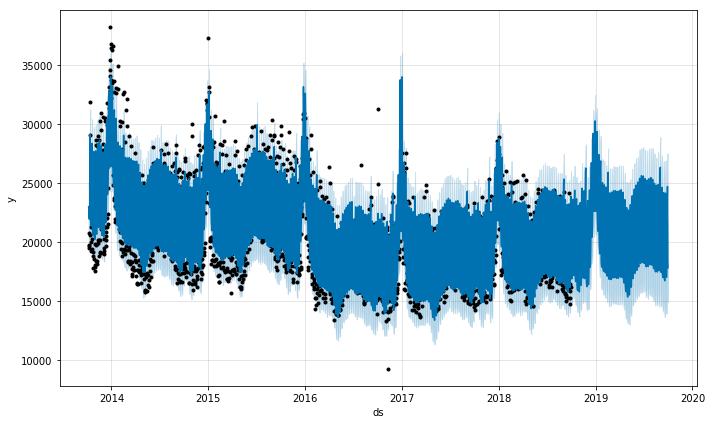

In [13]:
netflix = pd.read_csv('netflix.googletrends.csv', parse_dates=['period'])

prophetdataframe = pd.DataFrame()
prophetdataframe['ds'] = netflix['period']
prophetdataframe['y'] = netflix['value']

m = Prophet(holidays=sales)
m.add_country_holidays(country_name="US")
m.fit(prophetdataframe)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

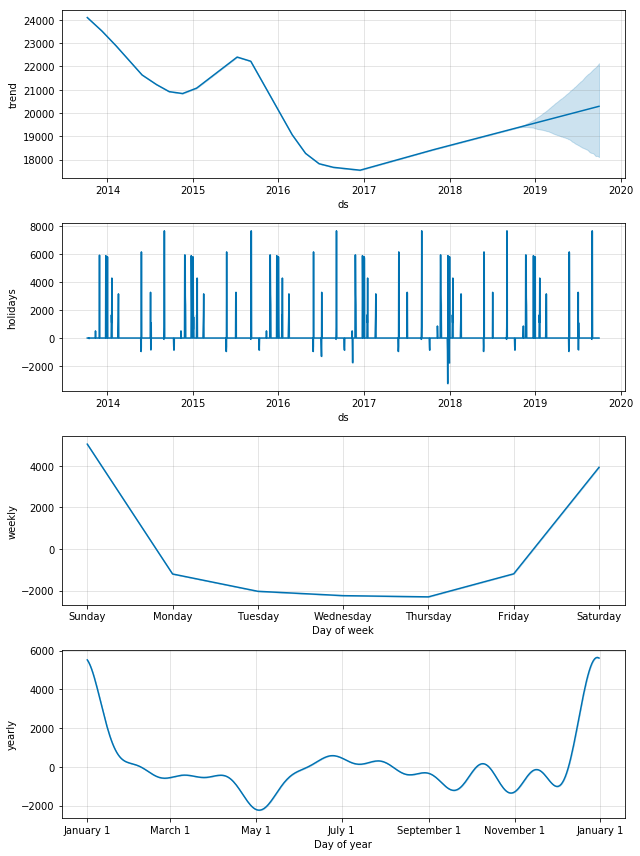

In [14]:
fig = m.plot_components(forecast)

In [15]:
forecast.to_csv('forecast.csv')

erroranalysis = m.predict(prophetdataframe)

erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

totalerror = erroranalysis['absoluteresiduals'].sum()
print(totalerror/len(erroranalysis))

1141.732636822493


Does this model incorporating holidays improve our error rate?

Yes! 

Our error has dropped from 1301 to 1142, which represents a 12% drop. Apparently holidays account for a lot of the big swings we were seeing before. 

Let's take a look at some of the outliers we are still seeing that were not explained by holidays.

In [16]:
print(erroranalysis.nlargest(10, 'absoluteresiduals'))

             ds         trend    yhat_lower    yhat_upper   trend_lower  \
1090 2016-10-01  17624.506739  19200.862379  23171.855652  17624.506739   
1182 2017-01-01  17593.024988  31997.902069  36063.666054  17593.024988   
1175 2016-12-25  17573.250187  31649.930008  35836.396454  17573.250187   
80   2013-12-26  23339.899392  24368.241965  28389.418586  23339.899392   
206  2014-05-01  21947.450259  15419.907344  19433.474705  21947.450259   
87   2014-01-02  23267.003711  24425.900529  28466.815151  23267.003711   
451  2015-01-01  21005.426104  28067.154840  32065.802262  21005.426104   
81   2013-12-27  23329.485723  25754.202919  29570.665107  23329.485723   
85   2013-12-31  23287.831049  24781.965963  28818.082463  23287.831049   
485  2015-02-04  21208.946067  16992.502430  21155.601454  21208.946067   

       trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
1090  17624.506739       0.000000             0.000000             0.000000   
1182  17593.0249

It is interesting to note that 7 out of 10 of our biggest outliers lie between Christmas and the day after New Year's. This tells us a lot about the end of year spike and how unpredictable it can be. Some holiday years drive especially strong traffic. 

What about the other 3? Can some digging help us discover why they are so far out of normal bounds?

On Feb 4, 2015 Netflix released a very popular trailer for the Daredevil series, which was its first Marvel show to host and would later be followed by several other popular shows including Jessica Jones and Luke Cage. 

On May 1, 2014 an error occurred in the Netflix system, which caused many popular shows to be inaccessible including Dexter, House, Grey’s Anatomy, How I Met Your Mother, and Suits. This caused not only a flurry of searches, but a large number of angry social media posts. 

On Oct 1, 2016 it turns out that the site was down for 2.5 hours and customers were frantically searching and posting to find out why. 

It is interesting to see that some of these high spikes were due to positive events such as a teaser trailer while others can be attributed to very bad press and upset customers.

There is one outlier not mentioned in our Top 10 offenders list that I would like to mention here. If you look towards the end of 2016 you'll see a dot way down below our normal trend. This represents Nov 9, 2016 or the day after the 2016 US Presidential election. It is quite obvious here that people were so absorbed on this day that they didn't stop to search for the latest Netflix news. This would be an interesting area to investigate further since it indicates that Netflix searches and possibly the watching time of its consumers considers big news stories to be in direct competition. 

Because many of these outliers are unpredictable in nature and unlikely to repeat (or hopefully not for the netflix server issues) we will remove these from our analysis so they do not impact our model. We will, however, keep the the large swings during the holiday season.

In [17]:
#Feb 4, 2015
date1 = pd.to_datetime("2015-02-04")
theindex1 = prophetdataframe[prophetdataframe.ds == date1].index
prophetdataframe = prophetdataframe.drop(theindex1)

#May 1, 2014
date2 = pd.to_datetime("2014-05-01")
theindex2 = prophetdataframe[prophetdataframe.ds == date2].index
prophetdataframe = prophetdataframe.drop(theindex2)

#Oct 1, 2016
date3 = pd.to_datetime("2016-10-01")
theindex3 = prophetdataframe[prophetdataframe.ds == date3].index
prophetdataframe = prophetdataframe.drop(theindex3)

#Nov 9, 2016
date4 = pd.to_datetime("2016-11-09")
theindex4 = prophetdataframe[prophetdataframe.ds == date4].index
prophetdataframe = prophetdataframe.drop(theindex4)

In [18]:
erroranalysis = m.predict(prophetdataframe)

erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

totalerror = erroranalysis['absoluteresiduals'].sum()
print(totalerror/len(erroranalysis))

3675.306752442972


This is a strange result. Why would eliminating 4 strong outliers result in such a large jump in MSE in our model? Regardless of the reason, this is a clear indication that we should keep these outliers in our model going forward since their elimination does not help us improve our model.

## Adspend Analysis

Does Netflix adspend have a direct impact on its Google search rate?

Let's start by importing some adspend data for Netflix and cleaning it up to begin our analysis.

In [19]:
adspend = pd.read_csv('netflix.adspend.csv')
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("WEEK OF", "", regex=True)
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace(" \(B\)", "", regex=True)
adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "", regex=True)

adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD'])
adspendnoproducts = adspend.pivot_table(index='FIXED TIME', aggfunc=np.sum)

Now let's take a look at the trends from this data, specifically for Cable TV, Newspaper, Spot TV, and the total advertising expenditure.

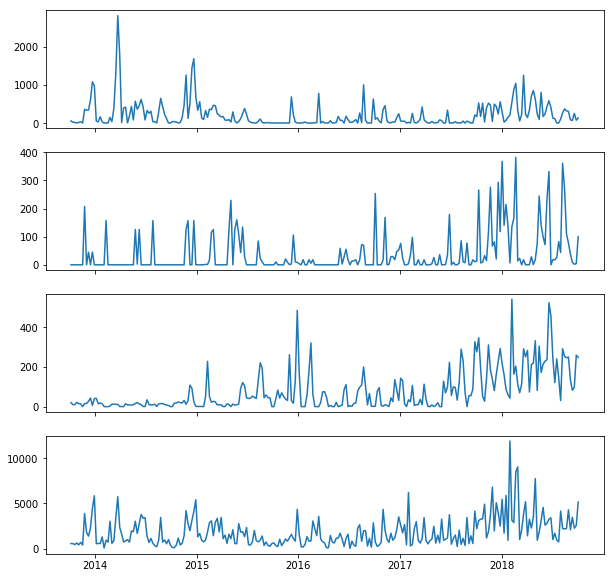

In [20]:
dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize = dimensions, sharex='all')

ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['NEWSPAPER'])
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV'])
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])

Looking at these 4 categories we see that there are clearly concentrated campaigns of adspend for each category and it is interesting to see that spending started to drastically increase in the end of 2017, beginning of 2018 which corresponds to the downward search volume in our analysis. This indicates to us that Netflix was well aware of its declining search volume and was trying to drum up interest through increased advertising. 

Now, let's concentrate spend on a weekly basis. 

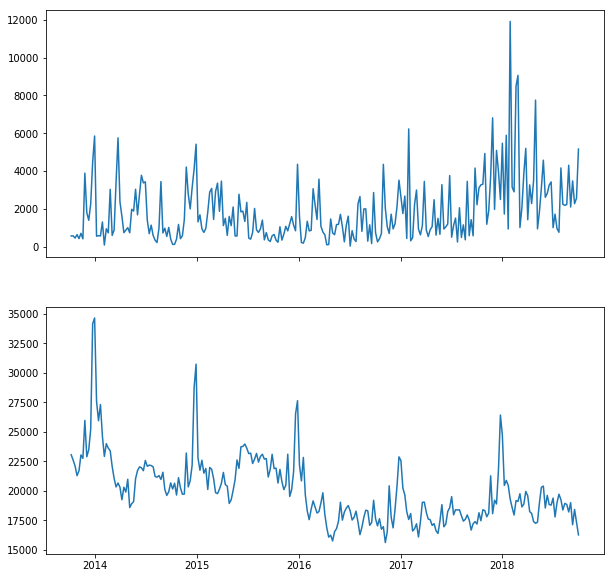

In [21]:
netflix = pd.read_csv('netflix.googletrends.csv', parse_dates = ['period'])
netflix.set_index('period', inplace=True)
netflixweekly = netflix.resample('W-MON', closed='left', label='left').mean()
netflixweekly = adspendnoproducts.join(netflixweekly)

dimensions = (10,10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex='all')

ax1.plot(netflixweekly.index, netflixweekly['TOTAL'])
ax2.plot(netflixweekly.index, netflixweekly['value'])

The first graph shows total ad spending across all platforms while the second graph shows the google trends search data across the same time period.

Again, it is interesting to note the increase in spending for 2017/2018 as Netflix sees its search volume decline. 

Can we see if there is an actual correlation here between this spending and search volume?

In [22]:
netflixweekly['TOTAL'].corr(netflixweekly['value'])

0.08088537281450656

It looks like the correlation between ad spending and Google searches is just over 8%, indicating a very weak relationship.

What happens if we compare differences over time? Can we see an increase the relationship if we compare these weekly differences rather than the totals? 

In [23]:
netflixweekly['TOTALdiff'] = netflixweekly['TOTAL'].diff(1)
netflixweekly['valuediff'] = netflixweekly['value'].diff(1)
netflixweekly.to_csv('adspend.googletrends.weekly.csv')

netflixweekly['TOTALdiff'].corr(netflixweekly['valuediff'])

0.1894262453164205

Wow, this is a big jump. We are still seeing a relatively weak relationship, but it is clear that the differences between weekly totals have a stronger connection than the totals themselves. 

Let's take a look at this adspend data a little more closely. 

In [24]:
adspend_trends = pd.read_csv('adspend.googletrends.weekly.csv', parse_dates=['FIXED TIME'])
adspend_trends.set_index('FIXED TIME', inplace=True)
adspend_trends = adspend_trends.drop(columns=['onediffvalue', 'Unnamed: 0', 'TOTALdiff', 'valuediff'])

Is our data stationary? Let's take a look at each variable to determine.

In [25]:
for acolumn in list(adspend_trends):
    adf_result = stattools.adfuller(adspend_trends[acolumn])
    print (acolumn)
    print(adf_result[1])

CABLE TV
4.944569609526588e-09
MAGAZINES
0.06237188986361679
NAT SPOT RADIO
0.6888967165130822
NATL NEWSP
0.5507690801310768
NETWORK RADIO
0.9967319472189904
NETWORK TV
5.200387873510148e-06
NEWSPAPER
0.09667874305370416
OUTDOOR
0.7976617760666814
SPOT TV
0.34853519025821755
SUNDAY MAGS
4.858038849581863e-29
SYNDICATION
0.2744078405823607
TOTAL
0.24171083022075313
value
0.05203085790517546


Wow, it looks like none of our variables are stationary. Let's correct this by using the value differences approach. 

In [26]:
adspend_trends_diff = pd.DataFrame()

for acolumn in list(adspend_trends):
    columnname = "%s_diff" % (acolumn)
    adspend_trends_diff[columnname] = adspend_trends[acolumn].diff(1)
    
for acolumn in list(adspend_trends_diff):
    adf_result = stattools.adfuller(adspend_trends_diff[acolumn].iloc[1:])
    print(adf_result[1])

2.737565394693417e-16
2.834615515519561e-14
8.44449296505387e-15
5.2624941219073705e-12
6.799586104486564e-06
4.097629531847151e-13
2.9107116033648535e-12
1.3630246836291944e-15
3.5528864600703405e-20
1.507821040229618e-13
1.8385816673648825e-17
7.158438380058312e-05
1.56605447214447e-13


Much better!

Now that we know our data is stationary, let's see how each variable is correlated with Googletrends searches.

In [27]:
correlationlist = []
for acolumn in list(adspend_trends_diff):
    if "value" not in acolumn:
        corr = adspend_trends_diff[acolumn].corr(adspend_trends_diff['value_diff'])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV_diff 0.22046734837928386
MAGAZINES_diff 0.06465845346503876
NAT SPOT RADIO_diff 0.017720865271109634
NATL NEWSP_diff 0.009172396420493547
NETWORK RADIO_diff -0.01311745343425895
NETWORK TV_diff 0.10275008912698835
NEWSPAPER_diff 0.14082039439974703
OUTDOOR_diff 0.09548383147823537
SPOT TV_diff 0.003966837989796766
SUNDAY MAGS_diff 0.03991149813749558
SYNDICATION_diff 0.12797358951527305
TOTAL_diff 0.18942624531642038


In [28]:
np.mean(correlationlist)

0.08326950800546862

It is interesting to see the differences in correlation between our different vairables. It looks like radio has no relationship with searches, but Cable and Network TV do. Overall, our Total spending differences have a 19% correlation, which is not high, but certainly worth considering. 

On average, each variable only have an 8% correlation, which is fairly low.

Let's compare this with our undifferenced data.

In [29]:
correlationlist = []
for acolumn in list(adspend_trends):
    if "value" not in acolumn:
        corr = adspend_trends[acolumn].corr(adspend_trends['value'])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV 0.21576417734316178
MAGAZINES 0.04518004492250076
NAT SPOT RADIO 0.0018193014226147218
NATL NEWSP -0.07414824884839409
NETWORK RADIO -0.03879898218091173
NETWORK TV 0.0419146907029724
NEWSPAPER 0.03526727607717213
OUTDOOR -0.08697616686958723
SPOT TV -0.12422361950610802
SUNDAY MAGS -0.019643233357082696
SYNDICATION 0.49425944662215826
TOTAL 0.08088537281450656


In [30]:
np.mean(correlationlist)

0.047608338261916905

When comparing our stationary data model our unstationary one, it is clear that the average of 5% correlation is much lower for our non-stationary model. This proves that our stationary model is much better in this situation is the one we should refer to going forward. 

Let's visualize our correlations of each variable against each other.

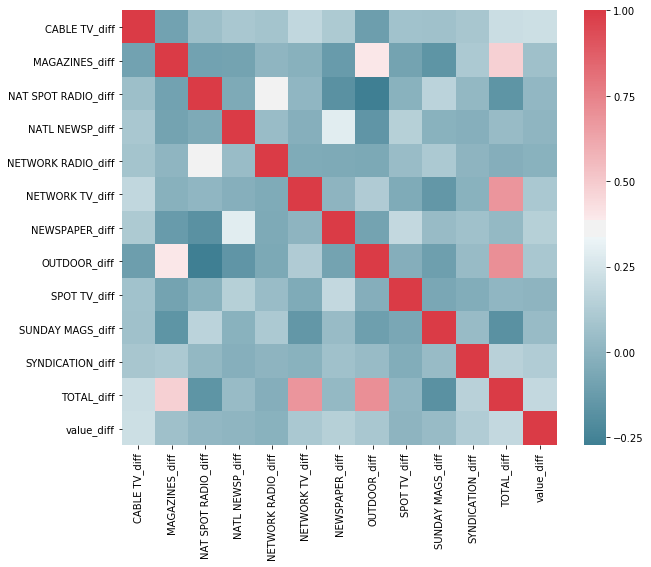

In [31]:
f, ax = pyplot.subplots(figsize=(10,8))
corr = adspend_trends_diff.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, ax=ax)

This heatmap showcases some important relationships between our variables. Unfortunately, for Googlesearch values this heat map simply confirms that our correlations with advertising variables are low, but we can still take a look at other relationships here. Looking at Total Differences, it is clear that the greatest amount of advertising expenditure is spent on magazines, network TV, and outdoor signs. Most of our relationships between individual variables are negative, which makes sense that if more advertising budget is spent on an area such as national spot radio then less will be spent on outdoor signs. 

## Granger Causality

Now, let's take a look at whether or not there is a significant lag in our data that we need to account for. We will start with the assumption that the impact of most ads for Netflix is immediate so we will look within an 8-week timeframe. We will look for the most significant lag in our dataset and see if there is a relationship pattern.

In [32]:
numofweeks = 8
significantlags = []

for acolumn in list(adspend_trends_diff):
    if 'value' not in acolumn:
        testframe = adspend_trends_diff[['value_diff', acolumn]]
        
        testframe = testframe.iloc[1:]
        results = stattools.grangercausalitytests(testframe, numofweeks, verbose=False)
        
        for week in range(1,numofweeks+1):
            if results[week][0]['params_ftest'][1] < .05:
                print('%s is significant at %s weeks' % (acolumn, week))
                significantlags.append(week)

CABLE TV_diff is significant at 1 weeks
NAT SPOT RADIO_diff is significant at 1 weeks
NAT SPOT RADIO_diff is significant at 3 weeks
NAT SPOT RADIO_diff is significant at 4 weeks
NAT SPOT RADIO_diff is significant at 5 weeks
NAT SPOT RADIO_diff is significant at 6 weeks
NAT SPOT RADIO_diff is significant at 7 weeks
NAT SPOT RADIO_diff is significant at 8 weeks
NETWORK RADIO_diff is significant at 3 weeks
NETWORK RADIO_diff is significant at 4 weeks
NETWORK RADIO_diff is significant at 5 weeks
NETWORK RADIO_diff is significant at 7 weeks
NETWORK RADIO_diff is significant at 8 weeks
OUTDOOR_diff is significant at 2 weeks
OUTDOOR_diff is significant at 3 weeks
OUTDOOR_diff is significant at 5 weeks
SUNDAY MAGS_diff is significant at 2 weeks
SUNDAY MAGS_diff is significant at 3 weeks
SUNDAY MAGS_diff is significant at 4 weeks
SUNDAY MAGS_diff is significant at 5 weeks
SUNDAY MAGS_diff is significant at 6 weeks
SUNDAY MAGS_diff is significant at 7 weeks
SUNDAY MAGS_diff is significant at 8 w

It looks like there is a significant range in lag time in our dataset depending on the variable. We are basically saying, how long after an ad campaign (or even specific ad view) does the desired result occur? In this case it is interesting to note that cable TV is only associated with a lag time for Google searches by 1 week whereas national radio spot and Sunday magazines are associated with searches up to 8 weeks so these campaigns seem to take much longer to take affect. 

It is important to keep in mind that the model doesn't tell us the strength of these relationships (which is a serious limitation), but does indicate where statistical significance is present. 

So what lag should we include in our model? 

Let's find the most common lag (mode) and use this measure to modify our data for this lag.

In [33]:
mode(significantlags)

5

Alright, now let's use 5 weeks as our measurement of lag.

In [34]:
modelingdataset = adspend_trends_diff

#add more timeslots to shift our data down
date = pd.to_datetime('2018-10-08')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-10-15')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-10-22')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-10-29')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-05')
modelingdataset.loc[date] = np.nan

In [35]:
for acolumn in list(modelingdataset):
    if 'value' not in acolumn:
        for alag in range(1,6): #lag at time 1 through lag time 5
            columnname = '%s_lag%s' % (acolumn, alag)
            modelingdataset[columnname] = modelingdataset[acolumn].shift(alag)

modelingdataset.sort_index(axis=1, inplace=True)

modelingdataset.to_csv('google_adspend_differenced_lagged_fordatarobot.csv')

In [36]:
#modelingdataset.tail(10)

In [37]:
alldata = pd.read_csv("google_adspend_differenced_lagged_fordatarobot.csv")
alldata.set_index(alldata['FIXED TIME'], inplace=True)
alldata = alldata.drop(columns=['FIXED TIME'])


In [38]:
alldata = alldata.iloc[:-6]
#alldata.tail()

In [39]:
alldata = alldata.iloc[6:]
#alldata.head()

Now that we have accounted for lag in our model, let's break out our predictors and values to start building a LASSO model.

In [40]:
listofallpredictors = []
for avar in list(alldata):
    if "value" not in avar:
        listofallpredictors.append(avar)
        
predictors = alldata[listofallpredictors]
target = alldata['value_diff']

Let's go ahead and assemble our model using ten-fold cross-validation and fit  the model with our training data.

In [41]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, test_size = .3, random_state=123)
model = LassoLarsCV(cv=10, precompute=False)

In [42]:
model = model.fit(pred_train.values, tar_train.values)

predictors_model = pd.DataFrame(listofallpredictors)
predictors_model.columns = ['label']
predictors_model['coeff'] = model.coef_

Let's take a look at the top coefficients.

In [43]:
for index, row in predictors_model.iterrows():
    if row['coeff'] > 0:
        print(row.values)

['CABLE TV_diff' 0.03738007795348626]
['CABLE TV_diff_lag1' 0.08276726545507766]
['NAT SPOT RADIO_diff_lag1' 0.5615125759076031]
['NETWORK TV_diff_lag5' 0.10170535465751428]
['SUNDAY MAGS_diff_lag3' 3.5587632626638763]
['SYNDICATION_diff' 0.1853622669491281]
['TOTAL_diff' 0.0689422086109872]


It looks like there are quite a few statistically significant coefficients for this model and the strongest relationships seem to belong to syndication and network TV. 

Now, what does our Mean Squared Error look like for this model?

In [44]:
train_error = mean_squared_error(tar_train, model.predict(pred_train))
print('training data MSE')
print(train_error)

training data MSE
2394226.5891003595


This error on our training data looks very similar to the error on our Facebook Prophet model, indicating it doesn't provide any extra level of accuracy.

Let's take a look at our R-Squared value for this model to see if it explains a large degree of the variability in our data.

In [45]:
rsquared_train = model.score(pred_train, tar_train)
print('training data r-squqare')
print(rsquared_train)


training data r-squqare
0.10586628655486552


This R-Squared value indicates that 10.5% of the variability in Google search trends can be explained by advertising expenditure. I am surprised by how low this result is considering how much emphasis is placed on advertising to incite curiosity and drive brand awareness.

Now, let's run our model against our test data to see what our R-Squared value is.

In [46]:
rsquared_test = model.score(pred_test, tar_test)
print('test data r-square')
print(rsquared_test)

test data r-square
-0.05614135689486455


Wow, negative. This is a clear sign that if we are truly looking to find what drives Google search trends for Netflix we need to dive into some other models or other data entirely.

## Twitter

Let's head in an entirely new direction and see if Twitter data might provide more of an explanation for what is driving searches than advertising spend. 

This data was obtained from SocialStudio and is a count of all tweets regarding Netflix and #Netflix each day for the past 3 years. Because this dataset is not an exact match for the timeline of our Googletrends dataset, we will need to cut out unfilled rows once the two datasets are merged. 

In [47]:
justtwitter = pd.read_csv('justtwitter.csv', parse_dates=['datetime'])
justtwitter['datetime'] = justtwitter['datetime'].dt.date
justtwitter.set_index('datetime', inplace=True)

In [48]:
twitter = justtwitter.join(netflix)

In [49]:
twitter.head()

,twittercount,Unnamed: 0,date,value,onediffvalue
datetime,,,,,
2016-03-09,60873,884.0,Mar 09 2016,16554.918455,877.072263
2016-03-10,56145,885.0,Mar 10 2016,15261.104215,-1293.814241
2016-03-11,59637,886.0,Mar 11 2016,16449.464795,1188.360580
2016-03-12,54513,887.0,Mar 12 2016,21813.453894,5363.989099
2016-03-13,58272,888.0,Mar 13 2016,23628.028473,1814.574578


In [50]:
twitter.tail()

,twittercount,Unnamed: 0,date,value,onediffvalue
datetime,,,,,
2019-03-04,83547,NaN,NaN,NaN,NaN
2019-03-05,65241,NaN,NaN,NaN,NaN
2019-03-06,83147,NaN,NaN,NaN,NaN
2019-03-07,69980,NaN,NaN,NaN,NaN
2019-03-08,42079,NaN,NaN,NaN,NaN


In [51]:
twitter = twitter.dropna(how='any')
withnan = twitter[twitter.isnull().any(axis=1)]
withnan.head()

,twittercount,Unnamed: 0,date,value,onediffvalue
datetime,,,,,


Let's take a look and see visually if we can see any relationship between total Netflix mentions on Twitter and total Google searches for Netflix.

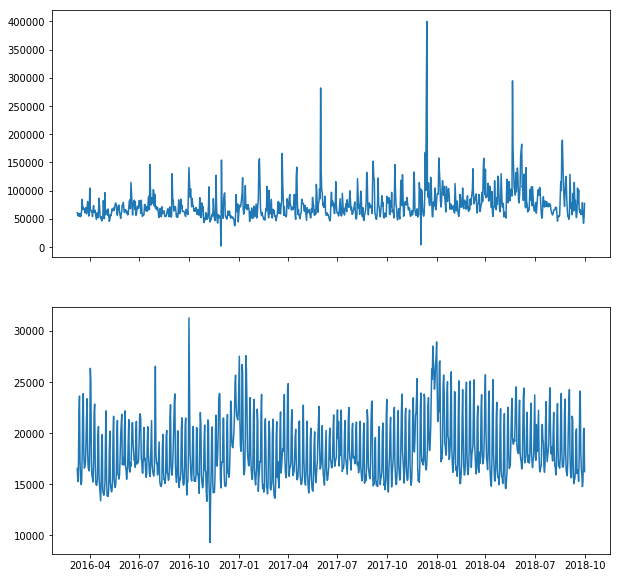

In [52]:
dimensions = (10,10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex='all')

ax1.plot(twitter.index, twitter['twittercount'])
ax2.plot(twitter.index, twitter['value'])

It looks like there might be some connections, but the data is pretty spikey so let's dive deeper.

Let's start by seeing if there is a general correlation between the totals.

In [53]:
twitter['twittercount'].corr(twitter['value'])

0.024008164924763407

2% seems like a very low correlation considering our initial correlation between advertising and searches was 8%.

What if we compared weekly differences?

In [54]:
twitter['twitterdiff'] = twitter['twittercount'].diff(1)

In [55]:
twitter = twitter[1:]
twitter['twitterdiff'].corr(twitter['onediffvalue'])

#twitter.head()

-0.10732084838159711

Well, now the relationship is stronger at 10.7%, but with an inverse relationship. This is an intriguing development.

Overall, what can we conclude about Twitter data and its influence on Google Search trends?

Let's take our twitter data and plug it into a Lasso model.

First, make sure we remove any missing values from our dataset. 

## Conclusions

Based on all of our models and adaptations there are a few consistent themes to keep in mind about Netflix data:

- High peak season is during the holidays from Thanksgiving to New Year's
- Low peak season is anytime the weather is nice, with the biggest dip happenning in May. 
- The weekly trend indicates that weekend searches are the most popular and mid-week is the least.
- Advertising expenditure does drive search interest, but is not stronly correlated.
- Forecasts are hopeful for a rebound in search trends, but there is a large degree of uncertainty. 
- Twitter posts indicate a negative correlation with Google search interest, indicating that people are likely to use    e    either social media or Google to find out the latest news, but not both. 